In [12]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [13]:
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

In [14]:
n = 8
n_node = 8

In [15]:
K = tc.set_backend('jax')

In [25]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_train == 9
x_train, y_train = x_train[~ind], y_train[~ind]
ind = y_train == 8
x_train, y_train = x_train[~ind], y_train[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

y_train = jax.nn.one_hot(y_train, n_node)
y_test = jax.nn.one_hot(y_test, n_node)

In [17]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return -jnp.mean(y * jnp.log(probs) + (1 - y) * jnp.log(1 - probs))
loss = K.jit(loss, static_argnums=[3])

In [18]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [21]:
k = 48

In [22]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0, 0/377: loss=0.3664, acc=0.2471
epoch 0, 50/377: loss=0.1283, acc=0.8750
epoch 0, 100/377: loss=0.1071, acc=0.9053
epoch 0, 150/377: loss=0.1011, acc=0.9004
epoch 0, 200/377: loss=0.0967, acc=0.9141
epoch 0, 250/377: loss=0.0967, acc=0.9033
epoch 0, 300/377: loss=0.0923, acc=0.9141
epoch 0, 350/377: loss=0.0932, acc=0.9180
epoch 1, 0/377: loss=0.1022, acc=0.8965
epoch 1, 50/377: loss=0.0941, acc=0.9111
epoch 1, 100/377: loss=0.0902, acc=0.9150
epoch 1, 150/377: loss=0.0897, acc=0.9219
epoch 1, 200/377: loss=0.0885, acc=0.9258
epoch 1, 250/377: loss=0.0922, acc=0.9043
epoch 1, 300/377: loss=0.0867, acc=0.9258
epoch 1, 350/377: loss=0.0888, acc=0.9150
epoch 2, 0/377: loss=0.0958, acc=0.9053
epoch 2, 50/377: loss=0.0921, acc=0.9092
epoch 2, 100/377: loss=0.0878, acc=0.9160
epoch 2, 150/377: loss=0.0874, acc=0.9209
epoch 2, 200/377: loss=0.0872, acc=0.9209
epoch 2, 250/377: loss=0.0890, acc=0.9092
epoch 2, 300/377: loss=0.0858, acc=0.9287
epoch 2, 350/377: loss=0.0867, acc=0.9199


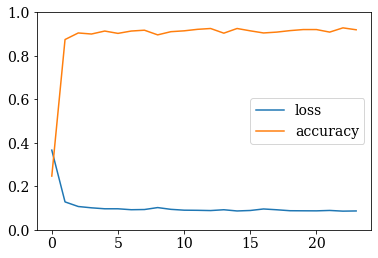

In [27]:
params_list = []
data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(128)

params = K.randn((k * 2, n), dtype=jnp.float32)
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)

loss_list = []
loss_list_train = []
acc_list = []
acc_list_train = []
for e in tqdm(range(3), leave=False):
    for i, (x, y) in enumerate(data):
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params, x, y, k)
        updates, opt_state = opt.update(grad_val, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_mean = jnp.mean(loss_val)
        if i % 50 == 0:
            acc = jnp.mean(compute_accuracy(params, x, y, k))
            acc_list_train.append(acc)
            loss_list_train.append(loss_mean)
            loss_mean = jnp.mean(compute_loss(params, x_test[:1024], y_test[:1024], k)[0])
            acc = jnp.mean(compute_accuracy(params, x_test[:1024], y_test[:1024], k))
            acc_list.append(acc)
            loss_list.append(loss_mean)
            print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 1)
plt.show()


In [28]:
def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

In [29]:
jnp.mean(pred(params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024].argmax(axis=-1))

DeviceArray(0.9042969, dtype=float32)

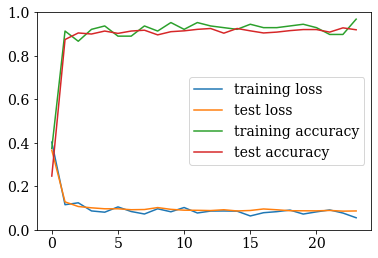

In [32]:
plt.plot(loss_list_train, label='training loss')
plt.plot(loss_list, label='test loss')
plt.plot(acc_list_train, label='training accuracy')
plt.plot(acc_list, label='test accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [33]:
jnp.save('cent_loss.npy', loss_list)
jnp.save('cent_acc.npy', acc_list)